In [ ]:
link origen: https://www.kaggle.com/code/georgyzubkov/store-sales-exploratory-data-analysis 

In [8]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno


In [13]:
train = pd.read_csv("Stores.csv")

# Información de la data

In [14]:
train

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620
...,...,...,...,...,...
891,892,1582,1910,1080,66390
892,893,1387,1663,850,82080
893,894,1200,1436,1060,76440
894,895,1299,1560,770,96610


El conjunto de datos está representado por cinco casos (uno no es informativo) y 896 objetos.

Eliminación de la información Store ID

In [28]:
train.drop(train.columns[[0]], axis = 1, inplace = True)

Store_Area: Área Física de la tienda en plaza de patio.

Items_Available: Número de artículos diferentes disponibles en la tienda correspondiente.

DailyCustomerCount: Número de clientes que visitaron las tiendas en promedio durante el mes.

Store_Sales: Ventas en (US$) que realizaron las tiendas.

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Items_Available       896 non-null    int64
 1   Daily_Customer_Count  896 non-null    int64
 2   Store_Sales           896 non-null    int64
dtypes: int64(3)
memory usage: 21.1 KB


# Exploración de datos

In [16]:
train.describe()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
count,896.000000,896.000000,896.000000,896.000000,896.000000
mean,448.500000,1485.409598,1782.035714,786.350446,59351.305804
std,258.797218,250.237011,299.872053,265.389281,17190.741895
min,1.000000,775.000000,932.000000,10.000000,14920.000000
25%,224.750000,1316.750000,1575.500000,600.000000,46530.000000
50%,448.500000,1477.000000,1773.500000,780.000000,58605.000000
75%,672.250000,1653.500000,1982.750000,970.000000,71872.500000
max,896.000000,2229.000000,2667.000000,1560.000000,116320.000000


Hipótesis: Hay valores atípicos en forma de supermercados muy pequeños y muy grandes. Pero, ¿son valores atípicos o son grupos separados de supermercados?

Analicemos las lagunas en los datos.

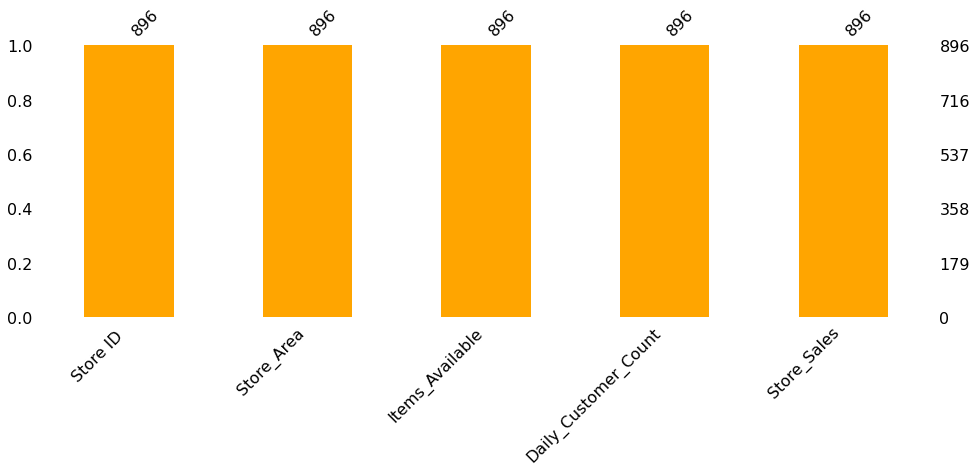

In [18]:
msno.bar(train,figsize = (16,5), color= "orange")
plt.show()

So se visualizan datos faltantes

Revisemos los datos para detectar la presencia de características categóricas.

In [20]:
for column_name in train.columns:
    unique_values = len(train[column_name].unique())
    print("Feature '{column_name}' has '{unique_values}' unique values".format(column_name = column_name,
                                                                                         unique_values=unique_values))
                                                                             

Feature 'Store ID ' has '896' unique values
Feature 'Store_Area' has '583' unique values
Feature 'Items_Available' has '616' unique values
Feature 'Daily_Customer_Count' has '130' unique values
Feature 'Store_Sales' has '816' unique values


No hay características categóricas. Analicemos la distribución de características.

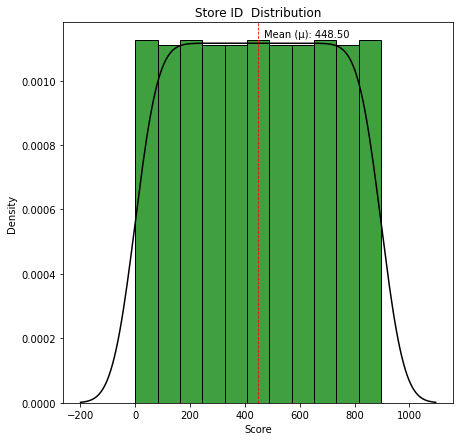

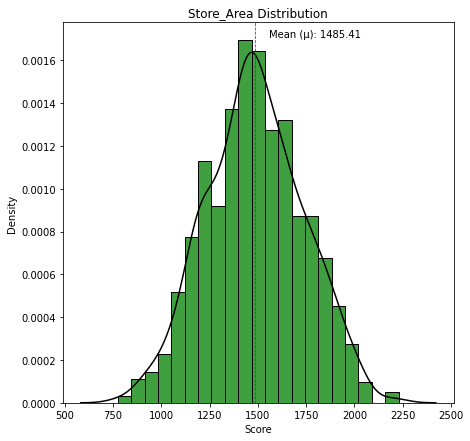

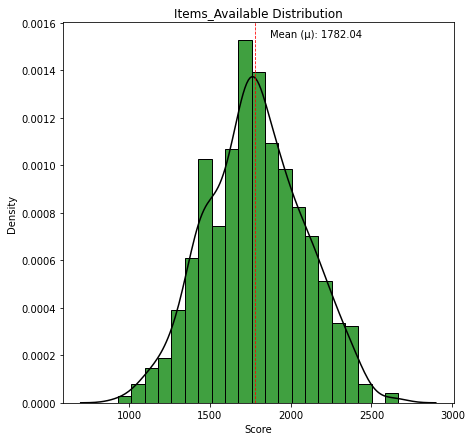

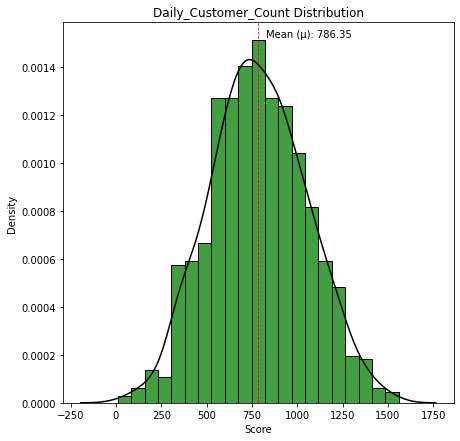

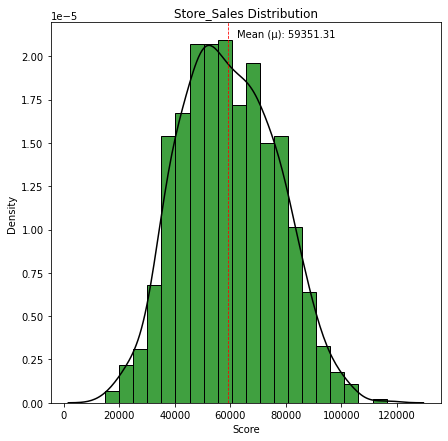

In [21]:
for column_name in train.columns:
  plt.figure(figsize=(7, 7))
  plt.title("{column_name} Distribution".format(column_name = column_name))
  sns.histplot(train[column_name], stat='density',color='green')
  sns.kdeplot(train[column_name], color='black')
  plt.axvline(train[column_name].mean(), color='red', linestyle='--', linewidth=0.8)
  min_ylim, max_ylim = plt.ylim()
  plt.text(train[column_name].mean()*1.05, max_ylim*0.96, 'Mean (μ): {:.2f}'.format(train[column_name].mean()))
  plt.xlabel("Score")
  plt.ylabel("Density")
  plt.show()

Distribución normal

Veamos la relación mutua entre las características.


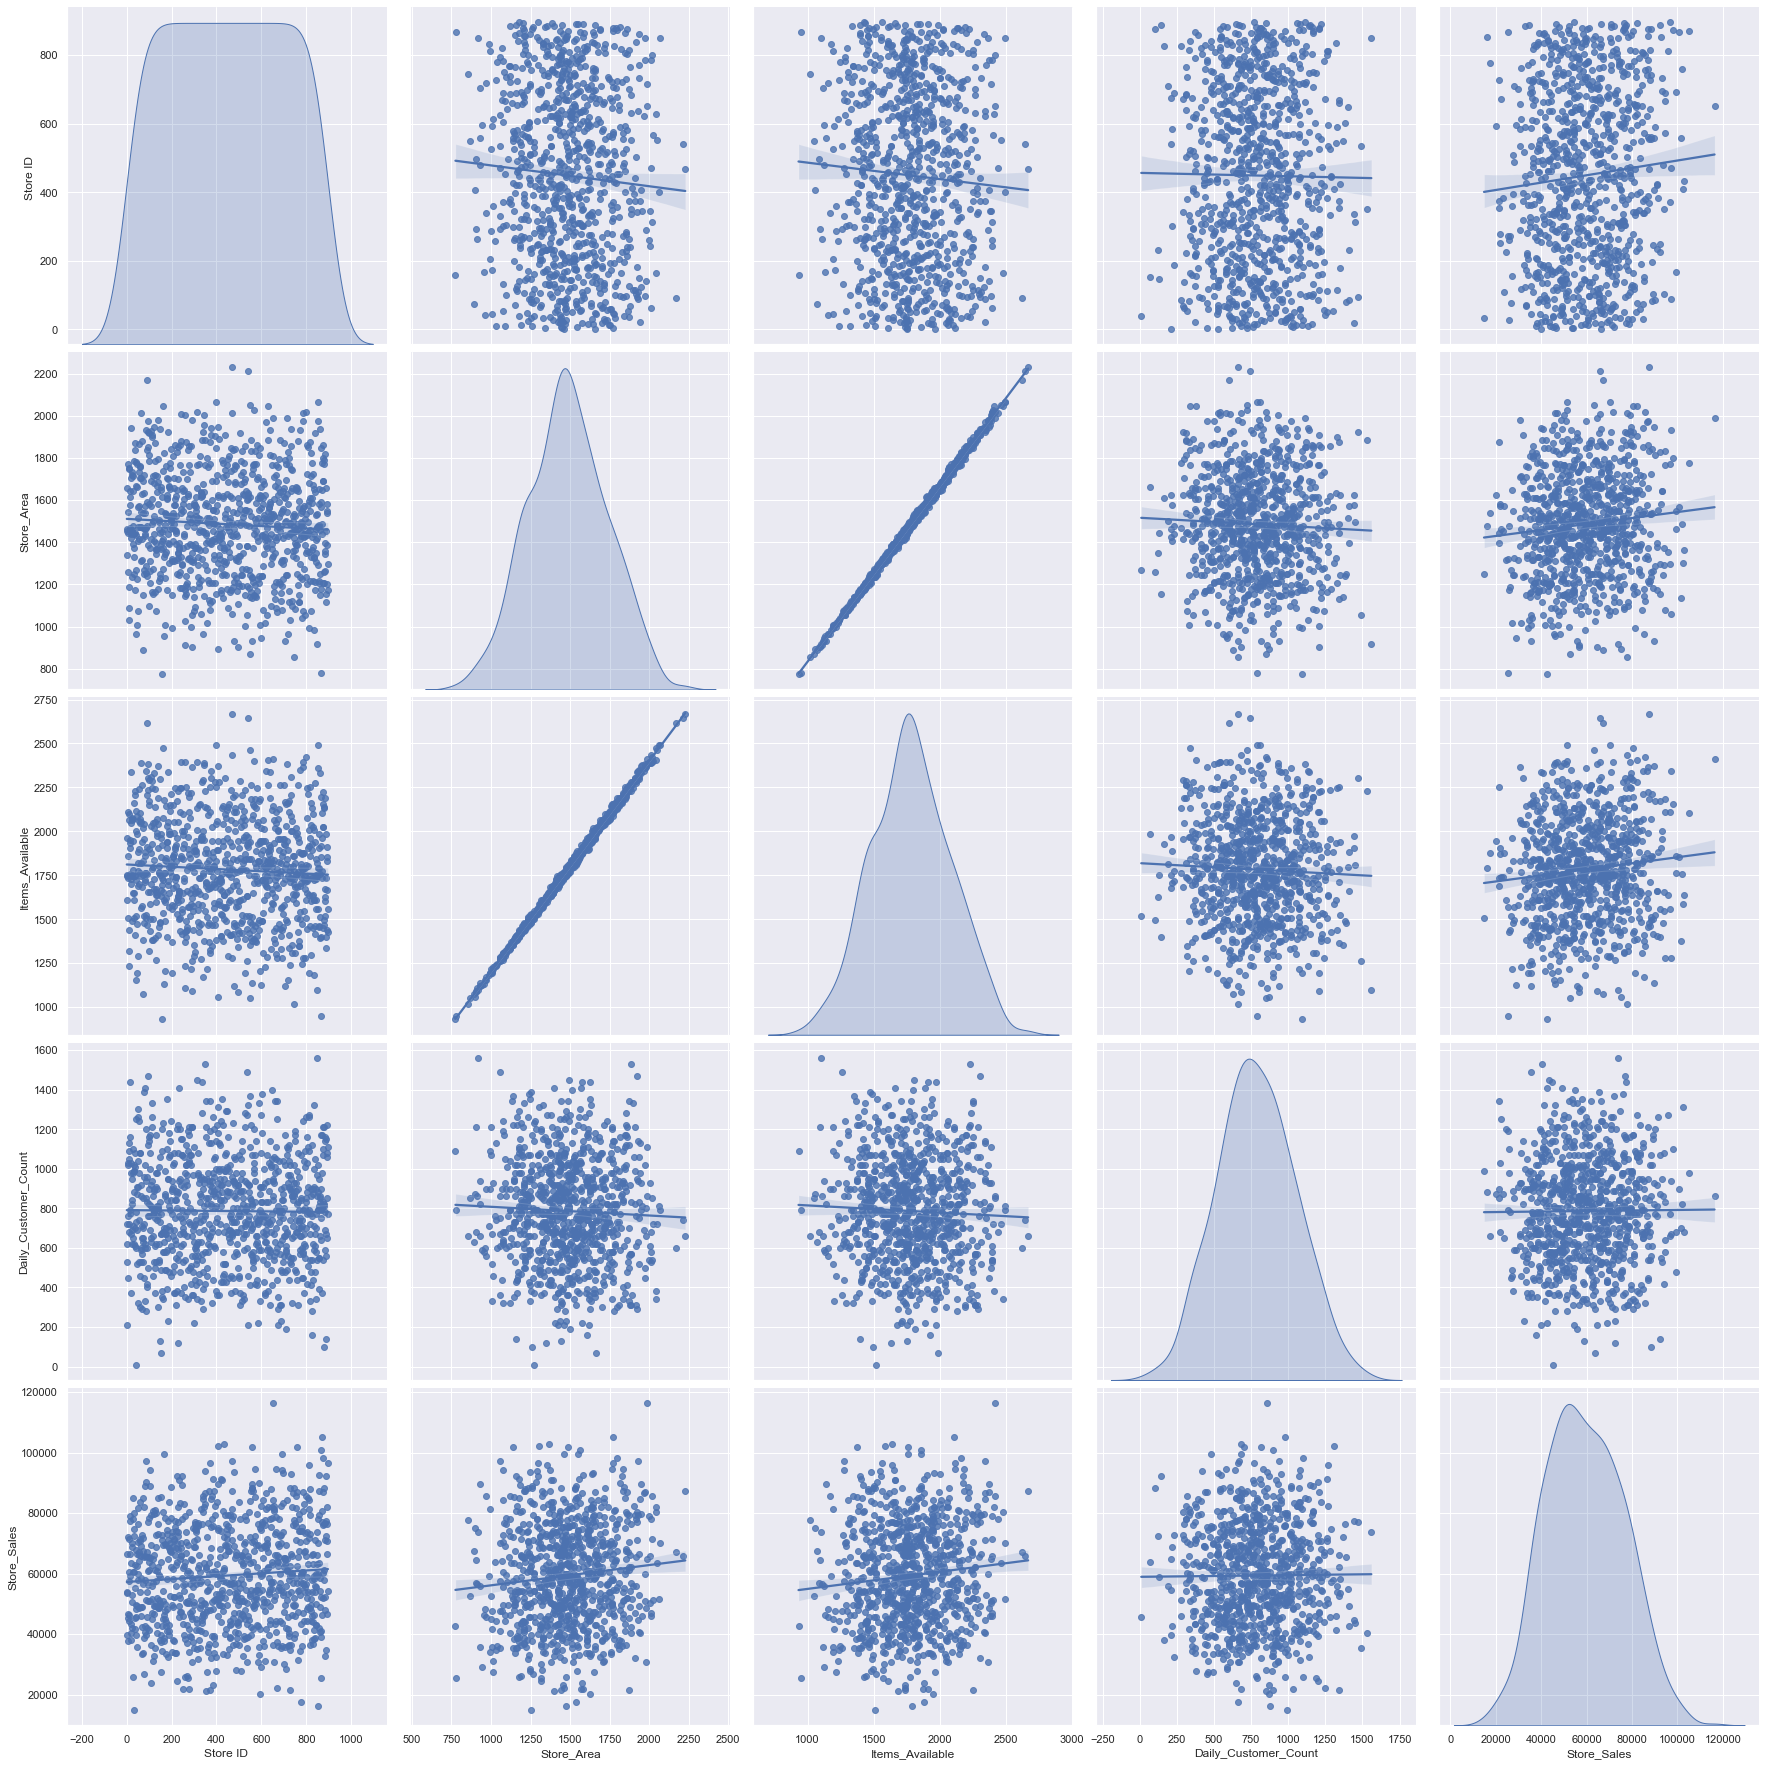

In [22]:
sns.set()
sns.pairplot(train,height = 5 ,kind ='reg',diag_kind='kde')
plt.show()


Conclusiones de los gráficos presentados: con el crecimiento del área de la tienda, aumenta la cantidad de artículos vendidos. La conclusión obvia es que nadie usará el área de la tienda para acomodar menos artículos)

Estamos interesados - en el indicador objetivo: la cantidad de dinero ganada por la tienda. Existe una ligera correlación entre el área de la tienda (productos vendidos) y la cantidad de dinero ganado. El número de clientes no depende de los ingresos. Para un análisis más completo de las tiendas, no hay suficiente variable de día de la semana 

Analicemos la presencia de valores atípicos en los datos. De acuerdo con la regla tácita, no se debe eliminar más del 2% de los datos (no más de 20 líneas del conjunto de datos en este caso).

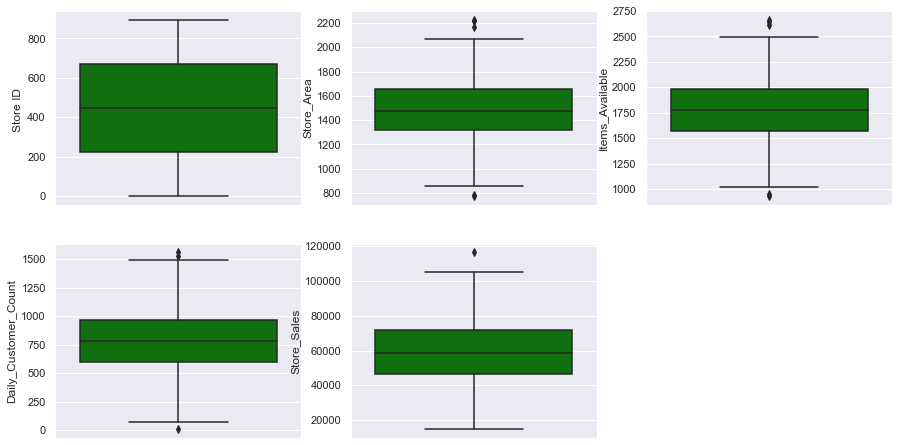

In [23]:
i=1
plt.figure(figsize=(15,25))
for feature in train.columns:
    plt.subplot(6,3,i)
    sns.boxplot(y=train[feature],color='green')
    i+=1

Hay valores atípicos menores en los datos. Los eliminaremos más tarde.

Realicemos un análisis de correlación de estas variables.

In [24]:
correlation = train.corr()
print(correlation['Store_Sales'].sort_values(ascending = False),'\n')

Store_Sales             1.000000
Items_Available         0.098849
Store_Area              0.097474
Store ID                0.071486
Daily_Customer_Count    0.008629
Name: Store_Sales, dtype: float64 



Index(['Store_Sales', 'Items_Available', 'Store_Area', 'Store ID ',
       'Daily_Customer_Count'],
      dtype='object')


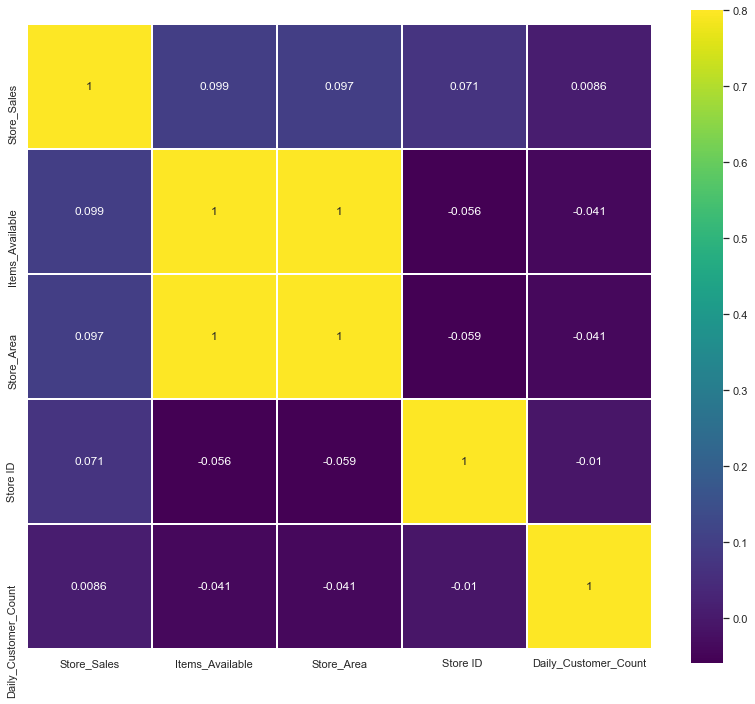

In [25]:
k= 10
cols = correlation.nlargest(k,'Store_Sales')['Store_Sales'].index
print(cols)
cm = np.corrcoef(train[cols].values.T)
f , ax = plt.subplots(figsize = (14,12))
sns.heatmap(cm, vmax=.8, linewidths=0.01,square=True,annot=True,cmap='viridis',
            linecolor="white",xticklabels = cols.values ,annot_kws = {'size':12},yticklabels = cols.values)
plt.show()

Los signos del área y los productos que se venden están completamente correlacionados, propongo eliminar uno de ellos.

In [26]:
train=train.drop('Store_Area', axis=1)

In [30]:
train

,Items_Available,Daily_Customer_Count,Store_Sales
0,1961,530,66490
1,1752,210,39820
2,1609,720,54010
3,1748,620,53730
4,2111,450,46620
...,...,...,...
891,1910,1080,66390
892,1663,850,82080
893,1436,1060,76440
894,1560,770,96610


# Cluster Analysis

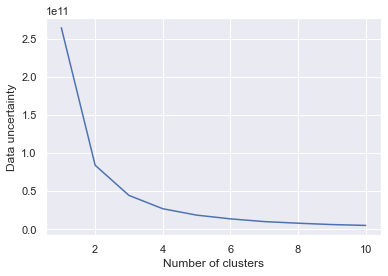

In [31]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    km = KMeans(n_clusters=i)
    km.fit_predict(train)
    wcss.append(km.inertia_)
fig, ax = plt.subplots()

ax.plot(range(1,11),wcss)

ax.set_xlabel('Number of clusters')
ax.set_ylabel('Data uncertainty')

plt.show()

Limpiaremos los datos de valores atípicos con la condición de eliminar no más del 2% del volumen de datos.

In [32]:
from sklearn.neighbors import LocalOutlierFactor

In [33]:
clf = LocalOutlierFactor(n_neighbors=5, contamination='auto')
y_pred = clf.fit_predict(train) 

In [34]:
train['Out']=y_pred

In [35]:
Out=train[train['Out']!=1]

In [36]:
Out.shape

(20, 4)

In [37]:
train2=train[train['Out']==1]

In [38]:
train2

,Items_Available,Daily_Customer_Count,Store_Sales,Out
0,1961,530,66490,1
1,1752,210,39820,1
2,1609,720,54010,1
3,1748,620,53730,1
4,2111,450,46620,1
...,...,...,...,...
891,1910,1080,66390,1
892,1663,850,82080,1
893,1436,1060,76440,1
894,1560,770,96610,1


Se realiza la limpieza de datos de valores atípicos.

In [39]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

In [40]:
y=train2['Store_Sales']
X=train2.drop(['Store_Sales','Out'],axis=1)

In [41]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [42]:
models = [RandomForestRegressor(), LinearRegression(),ElasticNet(), KNeighborsRegressor(),xgb.XGBRegressor()]
scores = dict()

for m in models:
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)

    print(f'model: {str(m)}')
    print(f'RMSE: {mean_squared_error(y_test,y_pred)}')
    print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
    print('-'*30, '\n')

model: RandomForestRegressor()
RMSE: 312792070.64872783
MAE: 14851.616977813856
------------------------------ 

model: LinearRegression()
RMSE: 254003891.85468093
MAE: 13228.167904160182
------------------------------ 

model: ElasticNet()
RMSE: 254003889.17001352
MAE: 13228.168461403227
------------------------------ 

model: KNeighborsRegressor()
RMSE: 298616812.84090906
MAE: 14487.511363636364
------------------------------ 

model: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimator

25% de la media. Creo que este es un buen resultado teniendo en cuenta que solo tenemos 2 características sin correlación con la variable objetivo.

Las ventas son uno de los primeros indicadores del rendimiento de la tienda. Si desea aumentar las ventas en la tienda, sus acciones estarán dirigidas a atraer clientes a la tienda o cómo aumentar el cheque promedio. ¿Qué método elegir para obtener el resultado más rápido? Para comprender cómo puede aumentar las ventas en la tienda, debe determinar a qué formato pertenece. ¿A qué comprador está destinado? *Algunas tiendas están dirigidas a compradores ahorrativos que desean obtener el costo más bajo. En otros, los clientes valoran más el servicio.

    * Si tiene una tienda de descuento, entonces el servicio no es significativo para él. La gente aguantará el paletizado, la mercancía en cajas. Pero se esforzarán por obtener precios favorables. El aumento de las ventas para los conscientes del presupuesto es, en primer lugar, un aumento de la factura media.
    
    * Si tiene un supermercado o una tienda de conveniencia, los precios no jugarán un papel tan importante. El comprador acude a él, queriendo recibir un cierto nivel de servicio. Tal comprador no quiere hacer cola y perder su precioso tiempo. Un aumento en las ventas en él es un aumento en la frecuencia de las compras.
    
    * Si necesita aumentar las ventas en la tienda con urgencia, entonces el método más fácil es aumentar el cheque promedio de la tienda. Los productos se colocan en áreas de exhibición adicionales, los productos de impulso se colocan en todas partes. La disponibilidad del producto está asegurada y la gente empieza a comprar cada vez más. El comprador vino por leche, pero en la entrada vio una montaña de frutas, en el camino notó su salchicha favorita, y a la salida el niño tomó un juguete. Y ahora, junto con la leche, el comprador ya tiene una cesta llena de productos.
    
    * Disponibilidad del producto. Esto es lo primero a lo que debe prestar atención si hay una tendencia negativa y necesita aumentar las ventas en la tienda. Si el producto no está en el estante, nadie lo comprará. El comprador debe saber que aquí siempre encontrará el requesón que necesita o su salchicha favorita.
    
    * Estimulación de las compras impulsivas. Incrementar de forma eficaz y rápida la factura media permite estimular las compras impulsivas. Esta es la compra de bienes que el comprador originalmente no planeó tomar. ¿Con qué frecuencia ha entrado en una tienda con la idea de comprar una lista de artículos, solo para encontrar muchos artículos no planificados en su carrito al momento de pagar? Todas estas son compras por impulso que te permiten aumentar las ventas en la tienda.
    
    * Calidad y presentación del producto. Llegas a la tienda y sientes que estás cómodo. Como resultado, pasa más tiempo en la tienda y compra más productos.
    
    * Aumento del volumen de compra. Los bienes se compran en un volumen mayor que el planeado originalmente. A menudo, el comprador está dispuesto a comprar más si la oferta es buena. Para ello se utilizan promociones, por ejemplo N+1 (“Dos por el precio de uno”). Cuando dos o más artículos se venden a mejor precio que uno. O acciones de promoción cruzada, cuando productos relacionados estimulan la venta entre sí (“compra un brasero y llévate leña de regalo”).
    
    * Crecimiento del precio medio del billete. Aumentar el precio medio de un cheque es más difícil que aumentar el número de productos y sus volúmenes. En este caso, el comprador debe dar preferencia a un producto más caro de lo que suele comprar. Esto es posible si el comprador siente que el valor del producto es superior a su precio. Servicio al cliente sincero. Explicación de los valores de las mercancías, estímulo para la compra de nuevos productos.
    
    * Aumento del número de compradores. Captar nuevos clientes te permite aumentar las ventas en la tienda, aunque requiere un esfuerzo e inversión importante. Como sabes, atraer a un nuevo cliente es más difícil que retener a uno antiguo. Es necesario concienciar a los posibles compradores y animarles a que hagan la primera compra.
    